In [28]:
# Import functions and libraries
import numpy as np
import math
import matplotlib.pyplot as plt
import queue as Queue
import threading
import time
import sys
import multiprocessing

from numpy import ones, zeros, pi, sin, cos, exp, sign, r_, mean, power
from numpy.fft import fft, fftshift, ifft, ifftshift
from scipy import signal
from scipy import integrate
import scipy.fftpack
from scipy.fftpack import dct, idct

import bitarray
from scipy.io.wavfile import read as wavread
import newax25 as ax25
from math import gcd
import sounddevice as sd
import RPi.GPIO as GPIO
from functools import reduce
import base64

from apng import APNG, PNG
from huffman import *
from PIL import Image

%matplotlib inline

# Data Compression

Choose file

42 52


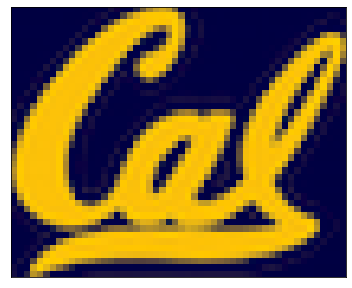

In [62]:
# Read APNG
os.system('rm -rf frames/*')
frames_folder = "frames/"
apng = APNG.open("Rolling.png")
# Save frames
frames = []
for i, (png, control) in enumerate(apng.frames):
    png.save(frames_folder + f"{i}.png")
    frames.append(np.array(Image.open(frames_folder + f"{i}.png"))[:, :, 0:3])
    
M, N = frames[0].shape[0:2]
print(M, N)
# Display image
plt.figure(figsize=(6,6))
plt.imshow(frames[0]), plt.xticks([]), plt.yticks([])
plt.show()

RGB to YCbCr

In [63]:
ycbcr_mat = np.array([[0.299, 0.587, 0.114],
                      [-0.168736, -0.331264, 0.5],
                      [0.5, -0.418688, -0.81312]]).T


def RGB2YCbCr(im_rgb):
    # Input:  a 3D float array, im_rgb, representing an RGB image in range [0.0,255.0]
    # Output: a 3D float array, im_ycbcr, representing a YCbCr image in range [-128.0,127.0]
    
    # Your code here
    imrgb = np.clip(im_rgb, 0.0, 255.0)
    im_ycbcr = imrgb @ ycbcr_mat
    im_ycbcr[:,:] += [-128., 0.0, 0.0]
    im_ycbcr = np.clip(im_ycbcr, -128.0, 127.0)
    # End of your code
    return im_ycbcr.astype(float)

def YCbCr2RGB(im_ycbcr):
    # Input:  a 3D float array, im_ycbcr, representing a YCbCr image in range [-128.0,127.0]
    # Output: a 3D float array, im_rgb, representing an RGB image in range [0.0,255.0]
    
    # Your code here
    im_ycbcr[:,:] += [128., 0.0, 0.0]
    im_rgb = im_ycbcr @ np.linalg.inv(ycbcr_mat)
    im_rgb = np.clip(im_rgb, 0.0, 255.0)
    # End of your code
    return im_rgb.astype(float)

frames_ycbcr = []
for frame in frames:
    frames_ycbcr.append(RGB2YCbCr(frame))

Chroma Downsampling

In [64]:
def chroma_downsample(C):
    # Input:  an MxN array, C, of chroma values
    # Output: an (M/2)x(N/2) array, C2, of downsampled chroma values
    
    # Your code here:
    C2 = np.array(Image.fromarray(C).resize((C.shape[1]//2, C.shape[0]//2), resample=Image.BILINEAR)).astype(float)
    # End of your code
    return C2

def chroma_upsample(C2):
    # Input:  an (M/2)x(N/2) array, C2, of downsampled chroma values
    # Output: an MxN array, C, of chroma values
    
    # Your code here:
    C = np.array(Image.fromarray(C2).resize((C2.shape[1]*2, C2.shape[0]*2), resample=Image.BILINEAR)).astype(float)
    # End of your code
    return C

Y_frames = [frame[:,:,0] for frame in frames_ycbcr]
Cb_frames = [frame[:,:,1] for frame in frames_ycbcr]
Cr_frames = [frame[:,:,2] for frame in frames_ycbcr]

Cb2_frames = [chroma_downsample(frame) for frame in Cb_frames]
Cr2_frames = [chroma_downsample(frame) for frame in Cr_frames]

(21, 26)


2D DCT

In [ ]:
def dct2(block):
    # Input:  a 2D array, block, representing an image block
    # Output: a 2D array, block_c, of DCT coefficients
    
    # Your code here:
    block_c = scipy.fftpack.dct(scipy.fftpack.dct(block, type=2, axis=1, norm='ortho'), type=2, axis=0, norm='ortho')
    # End of your code
    return block_c

def idct2(block_c):
    # Input:  a 2D array, block_c, of DCT coefficients
    # Output: a 2D array, block, representing an image block
    
    # Your code here:
    block = scipy.fftpack.idct(scipy.fftpack.idct(block_c, type=2, axis=1, norm='ortho'), type=2, axis=0, norm='ortho')
    # End of your code
    
    return block

# Transmission Pipeline

Generate config

In [11]:
# Enter your address here
myaddress = "6433 Telegraph Ave Oakland CA USA"

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="EE123")
location = geolocator.geocode(myaddress, timeout=None)

lat = "lat=%d^%2.2f%s" % (int(abs(location.latitude)),
                          60*(abs(location.latitude) - abs(math.floor(location.latitude))),
                          ("N") if location.latitude >0 else "S" )  
long = "long=%d^%2.2f%s" % (int(abs(location.longitude)),
                            60*(abs(location.longitude) - math.floor(abs(location.longitude))),
                          ("W") if location.longitude <0 else "E" )  

# enter your callsign and comment for the beacon
callsign = "EE1235-1"
comment = "git"

# generate passcode
callsignr = callsign.split('-')[0].upper()
code = 0x73e2
for i, char in enumerate(callsignr):
    code ^= ord(char) << (8 if not i % 2 else 0)

passcode = code & 0x7fff
print("Passcode:", passcode)

import os

cmd = "cat direwolf-loopback-DRAFT.conf  | sed  's/EE123_CALL/"+callsign+"/g'  | "
cmd = cmd +  "sed  's/EE123_PASSCODE/%d/g' | " % (passcode)
cmd = cmd +  "sed  's/EE123_COMMENT/comment=\"%s\"/g' | " % (comment)
cmd = cmd +  "sed  's/EE123_LATCOORD/%s/g' | " % (lat)
cmd = cmd +  "sed  's/EE123_LONGCOORD/%s/g' > direwolf-loopback.conf" % (long)
print(cmd)
os.system(cmd)  # NOTE: this is poor security practice, but conveniently concise here

Passcode: 13472
cat direwolf-loopback-DRAFT.conf  | sed  's/EE123_CALL/EE1235-1/g'  | sed  's/EE123_PASSCODE/13472/g' | sed  's/EE123_COMMENT/comment="git"/g' | sed  's/EE123_LATCOORD/lat=37^51.05N/g' | sed  's/EE123_LONGCOORD/long=122^15.65W/g' > direwolf-loopback.conf


0

Devices

In [17]:
builtin_idx = 0
usb_idx = 1
loop_idx = 3  # Use loopback dev 1! direwolf is connected to dev 0.
loop_idx_rcv = 2 # Use loopback dev 0. 
sd.default.samplerate = 48000
sd.default.channels = 1

TNC

In [18]:
# You can copy the compiled libpll.c from Part II or recompile pll.c with this command
!cc -fPIC -shared -o libpll.so pll.c

import numpy.ctypeslib as npct
from ctypes import c_int
from ctypes import c_float

array_1d_int = npct.ndpointer(dtype=np.int, ndim=1, flags='CONTIGUOUS')

libcd = npct.load_library("./libpll", ".")
libcd.pll.restype = c_int
libcd.pll.argtypes= [array_1d_int, c_int, array_1d_int,array_1d_int,  array_1d_int,array_1d_int, c_int, c_float]


class TNCaprs: 
    def __init__(self, fs=48000.0, Abuffer=1024, Nchunks=10):
        
        #  Implementation of an afsk1200 TNC. 
        #
        #  The TNC processes `Abuffer` long buffers until `Nchunks` number of buffers are 
        #  collected into a large one.
        #  This is because python is able to more efficiently process larger buffers than smaller ones.
        #  Then, the resulting large buffer is demodulated, sampled, and packets extracted.
        #
        # Inputs:
        #   fs      - sampling rate
        #   TBW     - TBW of the demodulator filters
        #   Abuffer - Input audio buffers from Pyaudio
        #   Nchunks - Number of audio buffers to collect before processing
        #   apll    - nudge factor of the PLL
        
        ## compute sizes based on inputs
        self.TBW = 2.0   # TBW for the demod filters
        self.N = (int(fs/1200*self.TBW)//2)*2+1   # length of the mark-space filters for demod
        self.fs = fs     # sampling rate   
        self.BW = 1200      # BW of filter based on TBW
        self.Abuffer = Abuffer             # size of audio buffer
        self.Nchunks = Nchunks             # number of audio buffers to collect
        self.Nbuffer = Abuffer*Nchunks+(self.N*3-3)         # length of the large buffer for processing
        self.Ns = 1.0*fs/1200.0 # samples per symbol
        
        ## state variables for the modulator
        self.prev_ph = 0  # previous phase to maintain continuous phase when recalling the function
        
        ## generate filters for the demodulator
        self.h_lp = signal.firwin(self.N,self.BW/fs*1.0,window='hanning')
        self.h_lpp = signal.firwin(self.N,self.BW*2*1.2/fs,window='hanning')
        self.h_space = self.h_lp*exp(1j*2*pi*(2200)*(r_[0:self.N]-self.N//2)/fs)
        self.h_mark = self.h_lp*exp(1j*2*pi*(1200)*(r_[0:self.N]-self.N//2)/fs)
        self.h_bp = signal.firwin(self.N,self.BW/fs*2.2,window='hanning')*exp(1j*2*pi*1700*(r_[0:self.N]-self.N//2)/fs)

        ## PLL state variables  -- so continuity between buffers is preserved
        self.dpll = np.round(2.0**32 / self.Ns).astype(np.int32)    # PLL step
        self.pll = 0                # PLL counter
        self.ppll = -self.dpll       # PLL counter previous value -- to detect overflow
        self.apll = 0.74             # PLL agressivness (small more agressive)
    
        ## state variable to NRZI2NRZ
        self.NRZIprevBit = bool(1)  
        
        ## State variables for findPackets
        self.state = 'search'   # state variable: 'search' or 'pkt'
        self.pktcounter = 0   # counts the length of a packet
        self.packet = bitarray.bitarray([0,1,1,1,1,1,1,0]) # current packet being collected
        self.bitpointer = 0   # pointer to advance the search beyond what was already 
                              # searched in the previous buffer

        ## state variables for processBuffer
        self.buff = zeros(self.Nbuffer)   # large overlap-save buffer
        self.chunk_count = 0              # chunk counter
        # bits from end of prev buffer to be copied to beginning of new
        self.oldbits = bitarray.bitarray([0,0,0,0,0,0,0])    
        self.Npackets = 0                 # packet counter
        
    
    def NRZ2NRZI(self,NRZ, prevBit=True):
        NRZI = NRZ.copy() 
        for n in range(0,len(NRZ)):
            if NRZ[n] :
                NRZI[n] = prevBit
            else:
                NRZI[n] = not(prevBit)
            prevBit = NRZI[n]
        return NRZI
    

    def NRZI2NRZ(self, NRZI):  
        NRZ = NRZI.copy() 
        for n in range(0,len(NRZI)):
            NRZ[n] = NRZI[n] == self.NRZIprevBit
            self.NRZIprevBit = NRZI[n]
        return NRZ
    
    
    def KISS2bits(self,KISS):
        # function that takes a KISS frame sent via TCP/IP and converts it to an APRSpacket bit stream.
        bits = bitarray.bitarray(endian="little")
        bits.frombytes(KISS)
        fcs = ax25.FCS()
        for bit in bits:
            fcs.update_bit(bit)
        
        bits.frombytes(fcs.digest())
        return bitarray.bitarray('01111110') + ax25.bit_stuff(bits) + bitarray.bitarray('01111110') 
     
        
    def bits2KISS(self,bits):
        # function that takes a bitstream of an APRS-packet, removes flags and FCS and unstuffs the bits
        bitsu = ax25.bit_unstuff(bits[8:-8])
        return  bitsu[:-16].tobytes() 
    
    
    def modulate(self,bits):
        # the function will take a bitarray of bits and will output an AFSK1200 modulated signal of them, 
        # sampled at fs Hz
        #  Inputs:
        #         bits  - bitarray of bits
        #         fs    - sampling rate
        # Outputs:
        #         sig    -  returns afsk1200 modulated signal
        
        fss = lcm((1200,self.fs))
        deci = fss//self.fs
    
        Nb = fss//1200
        nb = len(bits)
        NRZ = ones((nb,Nb))
        for n in range(0,nb):
            if bits[n]:
                NRZ[n,:]=-NRZ[n,:]
    
        freq = 1700 + 500*NRZ.ravel()
        ph = self.prev_ph + 2.0*pi*integrate.cumtrapz(freq)/fss
        sig = cos(ph[::deci])       
        return sig 
    
    
    def modulatePacket(self, callsign, digi, dest, info, preflags=80, postflags=80):
        # given callsign, digipath, dest, info, number of pre-flags and post-flags, the function contructs
        # an appropriate APRS packet, then converts it to NRZI and calls `modulate` 
        # to afsk1200 modulate the packet. 
        
        packet = ax25.UI(destination=dest,source=callsign, info=info, digipeaters=digi.split(b','),)
        prefix = bitarray.bitarray(np.tile([0,1,1,1,1,1,1,0],(preflags,)).tolist())
        suffix = bitarray.bitarray(np.tile([0,1,1,1,1,1,1,0],(postflags,)).tolist())
        sig = self.modulate(self.NRZ2NRZI(prefix + packet.unparse()+suffix))

        return sig
    

    def demod(self, buff):
        # Demodulates a buffer and returns NRZa. Make sure you only return valid samples.
    
        SIG = np.convolve(buff,self.h_bp,mode='valid')
        NRZa = abs(np.convolve(SIG,self.h_mark,mode='valid')) - abs(np.convolve(SIG,self.h_space,mode='valid'))
        NRZa = np.convolve(NRZa,self.h_lpp,mode='valid')
        return NRZa


    def FastPLL(self,NRZa):
        recbits = np.zeros(len(NRZa)//(self.fs//1200)*2,dtype=np.int32)
        pll = np.zeros(1,dtype = np.int32)
        pll[0] = self.pll
        ppll = np.zeros(1,dtype = np.int32)
        ppll[0] = self.ppll
                
        NRZb = (NRZa > 0).astype(np.int32)
        tot = libcd.pll(NRZb,len(NRZb),recbits,recbits,pll,ppll,self.dpll,self.apll)
        
        self.ppll = ppll.copy()
        self.pll = pll.copy()
        
        return bitarray.bitarray(recbits[:tot].tolist())
    
    
    def PLL(self, NRZa):
        idx = zeros(len(NRZa)//int(self.Ns)*2)   # allocate space to save indices        
        c = 0
        
        for n in range(1,len(NRZa)):
            if (self.pll < 0) and (self.ppll >0):
                idx[c] = n
                c = c+1
        
            if (NRZa[n] >= 0) !=  (NRZa[n-1] >=0):
                self.pll = np.int32(self.pll*self.apll)    
        
            self.ppll = self.pll
            self.pll = np.int32(self.pll+ self.dpll)
    
        return idx[:c].astype(np.int32) 
    

    def findPackets(self,bits):
        # function take a bitarray and looks for AX.25 packets in it. 
        # It implements a 2-state machine of searching for flag or collecting packets
        flg = bitarray.bitarray([0,1,1,1,1,1,1,0])
        packets = []
        n = self.bitpointer
        
        # Loop over bits
        while (n < len(bits)-7) :
            # default state is searching for packets
            if self.state is 'search':
                # look for 1111110, because can't be sure if the first zero is decoded
                # well if the packet is not padded.
                if bits[n:n+7] == flg[1:]:
                    # flag detected, so switch state to collecting bits in a packet
                    # start by copying the flag to the packet
                    # start counter to count the number of bits in the packet
                    self.state = 'pkt'
                    self.packet=flg.copy()
                    self.pktcounter = 8
                    # Advance to the end of the flag
                    n = n + 7
                else:
                    # flag was not found, advance by 1
                    n = n + 1             
            # state is to collect packet data. 
            elif self.state is 'pkt':
                # Check if we reached a flag by comparing with 0111111
                # 6 times ones is not allowed in a packet, hence it must be a flag (if there's no error)
                if bits[n:n+7] == flg[:7]:
                    # Flag detected, check if packet is longer than some minimum
                    if self.pktcounter > 200:
                        #print('packet found!')
                        # End of packet reached! append packet to list and switch to searching state
                        # We don't advance pointer since this our packet might have been
                        # flase detection and this flag could be the beginning of a real packet
                        self.state = 'search'
                        self.packet.extend(flg)
                        packets.append(self.packet.copy())
                    else:
                        # packet is too short! false alarm. Keep searching 
                        # We don't advance pointer since this this flag could be the beginning of a real packet
                        self.state = 'search'
                # No flag, so collect the bit and add to the packet
                else:
                    # check if packet is too long... if so, must be false alarm
                    if self.pktcounter < 2680:
                        # Not a false alarm, collect the bit and advance pointer        
                        self.packet.append(bits[n])
                        self.pktcounter = self.pktcounter + 1
                        n = n + 1
                    else:  #runaway packet
                        #runaway packet, switch state to searching, and advance pointer
                        self.state = 'search'
                        n = n + 1
        
        self.bitpointer = n-(len(bits)-7) 
        return packets

    
    # function to generate a checksum for validating packets
    def genfcs(self,bits):
        # Generates a checksum from packet bits
        fcs = ax25.FCS()
        for bit in bits:
            fcs.update_bit(bit)
    
        digest = bitarray.bitarray(endian="little")
        digest.frombytes(fcs.digest())

        return digest


    # function to parse packet bits to information
    def decodeAX25(self,bits, deepsearch=False):
        ax = ax25.AX25()
        ax.info = "bad packet"
        ax.parse(bits)
        return ax
    
    
    def processBuffer(self, buff_in):
        # function processes an audio buffer. It collect several small into a large one
        # Then it demodulates and finds packets.
        #
        # The function uses overlap and save convolution
        # The function returns packets when they become available. Otherwise, returns empty list
        
        N = self.N
        NN = N*3 - 3
        
        Nchunks = self.Nchunks
        Abuffer = self.Abuffer
        fs = self.fs
        Ns = self.Ns
        
        validPackets=[]
        packets=[]
        NRZI=[]
        idx = []
        bits = []
        
        # Fill in buffer at the right place
        self.buff[NN+self.chunk_count*Abuffer:NN+(self.chunk_count+1)*Abuffer] = buff_in.copy()
        self.chunk_count = self.chunk_count + 1  
        
        # number of chunk reached -- process large buffer
        if self.chunk_count == Nchunks:
            # Demodulate to get NRZI
            NRZI = self.demod(self.buff)
            
            # compute sampling points, using PLL
            bits = self.FastPLL(NRZI)
            # In case that buffer is too small, raise an error -- must have at least 7 bits worth
            if len(bits) < 7:
                raise ValueError('number of bits too small for buffer')
            
            # concatenate end of previous buffer to current one
            bits = self.oldbits + self.NRZI2NRZ(bits)
            
            # store end of bit buffer to next buffer
            self.oldbits = bits[-7:].copy()
            
            # look for packets
            packets = self.findPackets(bits)
            
            # Copy end of sample buffer to the beginning of the next (overlap and save)
            self.buff[:NN] = self.buff[-NN:].copy()
            
            # reset chunk counter
            self.chunk_count = 0
            
            # checksum test for all detected packets
            for n in range(0,len(packets)):
                if len(packets[n]) > 200: 
                    try:
                        ax = self.decodeAX25(packets[n])
                    except:
                        ax = ax25.AX25()
                        ax.info = "bad packet"
                    if ax.info != 'bad packet' and ax.info != 'no decode':
                        validPackets.append(packets[n])                
  
        return validPackets

Task 5

In [19]:
# Convert from bitarray class to b64 bytes and back
def ee123_bitarr_to_base64(bits: bitarray.bitarray):
    bN = np.uint32(len(bits)).tobytes()
    mybytes = bN + bits.tobytes()
    return base64.b64encode(mybytes)

def ee123_base64_to_bitarr(b64: str):
    mybytes = base64.b64decode(b64)  # Be careful not to overwrite the builtin bytes class!
    N = np.frombuffer(mybytes[:4], dtype='<u4')[0]
    ba = bitarray.bitarray()
    ba.frombytes(mybytes[4:])
    return ba[:N]

def file_to_b64(fname):
    with open(fname, 'rb') as f:
        raw = f.read()
    # Prepend the number of bytes before encoding
    b64 = base64.b64encode(np.uint32(len(raw)).tobytes() + raw)
    return b64

def enqueue_data(callsign, modem, data, address=None, uid=None, fname="myfile.bin", 
                 comment="UCB EE123 message format", dest=b"APCAL", bsize=240):
    """
    Inputs:
      callsign: your callsign
      modem: a modem object
      data: data to send as a bytes object
      address: address callsign for the message, defaults to your callsign
      uid: optionally specify a UID, otherwise one will be randomly chosen
      fname: filename to send in start packet
      comment: comment for start packet
      dest: should be APCAL for EE123 data
      bsize: number of bytes to send per packet
      
    Outputs:
      Qout: a queue containing modulated packets to transmit
      uid: the uid used for this data transfer
    """
    if address is None:
        address = callsign
    if uid is None:
        uid = np.random.randint(0, 10000)
    uid = bytes("{:04d}".format(uid), 'utf-8')
    print("Putting packets in Queue for transmission ID=%s" % uid.decode())
    
    Qout = Queue.Queue()
    
    Digi = b'WIDE1-1'

    # Enqueue START packet
    addr = bytes(':{:<9}:'.format(address), 'utf-8')
    # addr, START, uid, filename, comment
    start = b','.join([addr + b'START' + uid, bytes(fname, 'utf-8'), bytes(comment, 'utf-8')])
    tmp = modem.modulatePacket(callsign=callsign, digi=Digi, dest=dest, info=start)
    Qout.put(tmp)
    # Enqueue data packets
    idx = 0
    while True:
        seq = bytes('{:04d}'.format(idx), 'utf-8')
        info = addr + data[idx*bsize:idx*bsize+bsize] + seq
        tmp = modem.modulatePacket(callsign=callsign, digi=Digi, dest=dest, info=info)
        Qout.put(tmp)
        
        idx += 1
        if idx * bsize > len(data):
            break
    # Enqueue END packet
    end = addr + b'END' + uid
    tmp = modem.modulatePacket(callsign=callsign, digi=Digi, dest=dest, info=end)
    Qout.put(tmp)

    return Qout, uid
    

In [ ]:
callsign = "EE1235-1"
fs = 48000
modem = TNCaprs(fs=fs, Abuffer=1024, Nchunks=10)
fname = "calBlue.tiff"

print("Putting packets in Queue")

# Enqueue the file
file_b64 = file_to_b64(fname)
Qout, uid = enqueue_data(
    callsign,
    modem,
    file_b64,
    fname=fname
)

print("Done. UID=%s" % uid.decode())
print(f"There are {Qout.qsize()} packets in Qout")